In [12]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%autoreload 2
import torch
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt
import e3nn
e3nn.set_optimization_defaults(jit_script_fx=False)

import e3tools
import rdkit
import rdkit.Chem as Chem

import torch._dynamo
torch._dynamo.config.suppress_errors = True

from bond_predictor import models, rdkit_utils

In [14]:
net = models.E3Conv()
net = torch.compile(net, dynamic=True, fullgraph=True)

32x0e+32x1o+32x0e+32x1o 256


In [15]:
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

64536


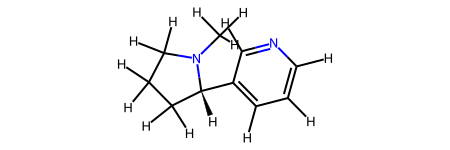

In [16]:
mol = Chem.MolFromSmiles('CN1CCC[C@H]1c2cccnc2')
mol = Chem.AddHs(mol)
mol

In [17]:
def visualize_bond_matrix(bond_matrix: torch.Tensor, atom_types: torch.Tensor):
    """
    Visualize bond matrix with atom labels
    
    Args:
        bond_matrix: NumPy array or tensor of bond types (num_atoms, num_atoms)
        atom_types: NumPy array or tensor of atom types (num_atoms,)
        atom_labels: Optional list of atom labels
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Convert to numpy if tensor
    if isinstance(bond_matrix, torch.Tensor):
        bond_matrix = bond_matrix.cpu().numpy()
    
    if atom_types is not None and isinstance(atom_types, torch.Tensor):
        atom_types = atom_types.cpu().numpy()
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Create atom labels if needed
    if atom_types is not None:
        atom_labels = [Chem.GetPeriodicTable().GetElementSymbol(int(atom_type)) for atom_type in atom_types]
    else:
        atom_labels = [str(i) for i in range(bond_matrix.shape[0])]
    
    # Create heatmap
    ax = sns.heatmap(
        bond_matrix, 
        annot=True, 
        cmap='viridis', 
        fmt='d',
        xticklabels=atom_labels,
        yticklabels=atom_labels
    )
    
    plt.title('Molecular Bond Matrix')
    plt.tight_layout()
    
    # Return the figure for display or saving
    return plt.gcf()

In [18]:
coordinates, atom_types, bond_matrix = rdkit_utils.embed_molecule_for_torch(mol)
print(f"Coordinates shape: {coordinates.shape}")
print(f"Atom types shape: {atom_types.shape}")
print(f"Bond matrix shape: {bond_matrix.shape}")

edge_index = e3tools.radius_graph(coordinates, r=3.0)
output = net(coordinates, atom_types, edge_index)
print(output.shape)

Coordinates shape: torch.Size([26, 3])
Atom types shape: torch.Size([26])
Bond matrix shape: torch.Size([26, 26])
torch.Size([26, 26, 5])


Molecule has 26 atoms
Coordinates shape: (26, 3)
Atom types: [6 7 6 6 6 6 6 6 6 6 7 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Bond matrix shape: (26, 26)


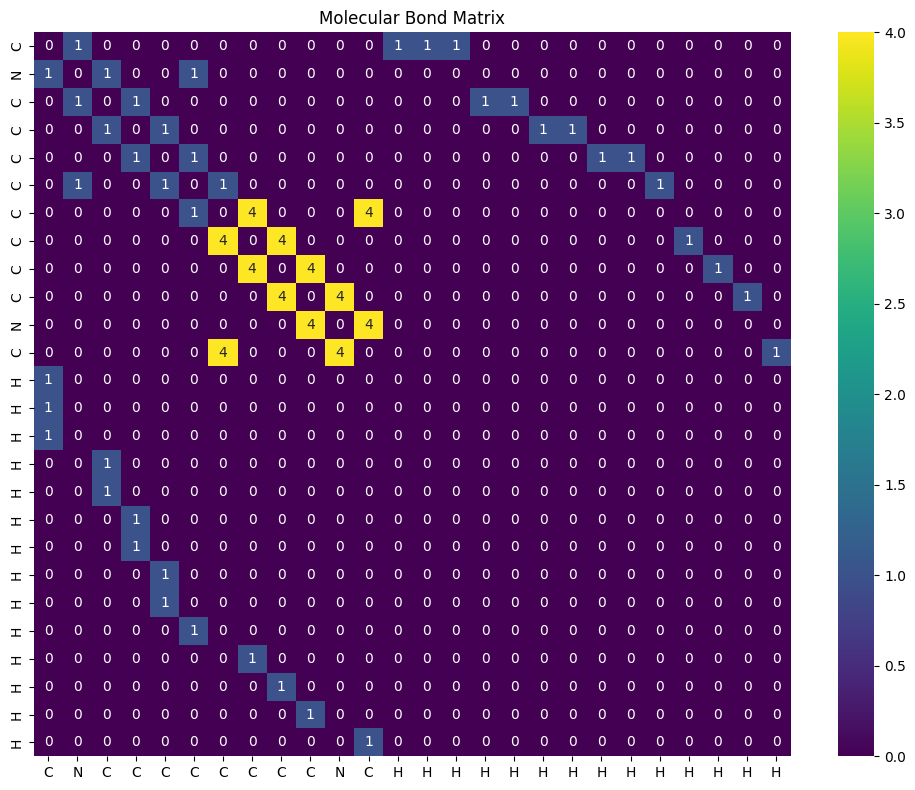

In [19]:
# Get bond matrix and features
coordinates, atom_types, bond_matrix = rdkit_utils.embed_molecule(mol)

print(f"Molecule has {len(atom_types)} atoms")
print(f"Coordinates shape: {coordinates.shape}")
print(f"Atom types: {atom_types}")
print(f"Bond matrix shape: {bond_matrix.shape}")

# Display bond matrix
fig = visualize_bond_matrix(bond_matrix, atom_types)
plt.show()

In [20]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

with tqdm.tqdm(range(1000)) as pbar:
    for step in pbar:
        optimizer.zero_grad()

        coordinates, atom_types, bond_matrix = rdkit_utils.embed_molecule_for_torch(mol)
        N = coordinates.shape[0]
    
        edge_index = e3tools.radius_graph(coordinates, r=net.radial_cutoff)
        output_logits = net(coordinates, atom_types, edge_index)
        output_logits = output_logits.reshape((N * N, -1))
        bond_matrix = bond_matrix.reshape((N * N,))
        loss = criterion(output_logits, bond_matrix)
        loss.backward()
        optimizer.step()

        accuracy = (output_logits.argmax(dim=-1) == bond_matrix).float().mean()
        accuracy_bonded = (output_logits[bond_matrix != 0].argmax(dim=-1) == bond_matrix[bond_matrix != 0]).float().mean()
        pbar.set_description(f"Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}, Accuracy Bonded: {accuracy_bonded.item():.4f}")



Loss: 0.0000, Accuracy: 1.0000, Accuracy Bonded: 1.0000: 100%|██████████| 1000/1000 [00:40<00:00, 24.45it/s]


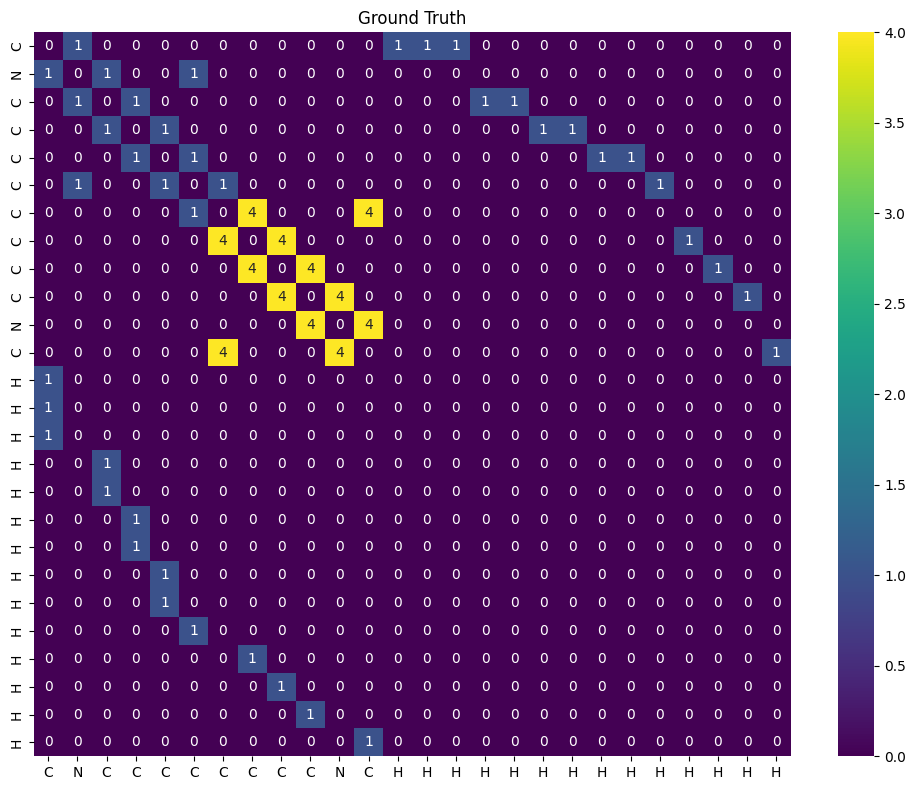

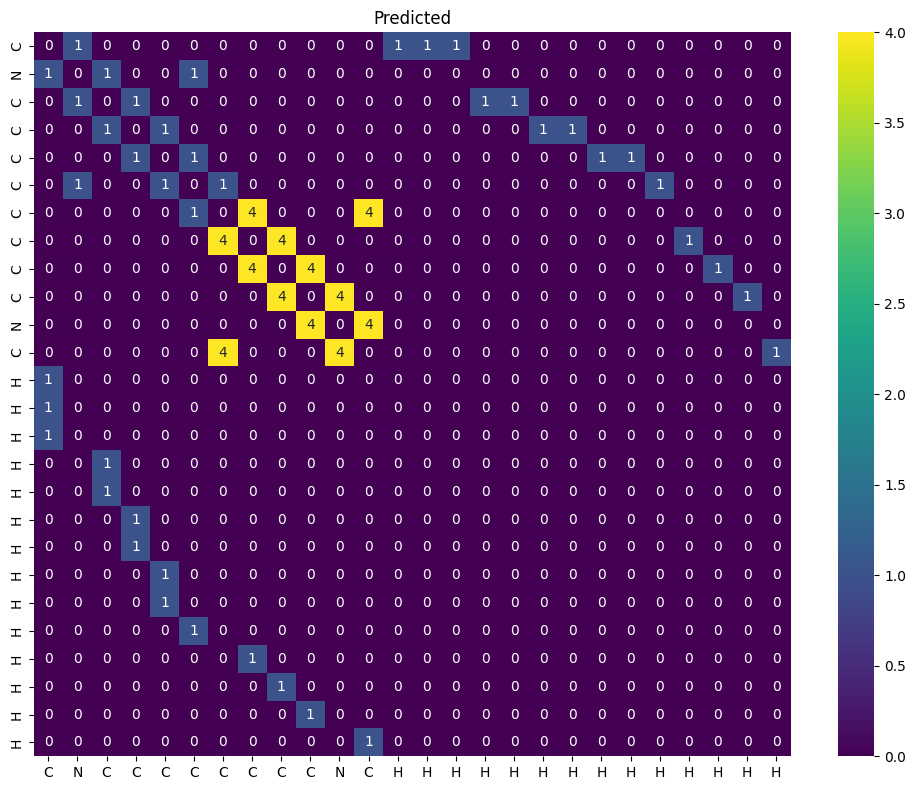

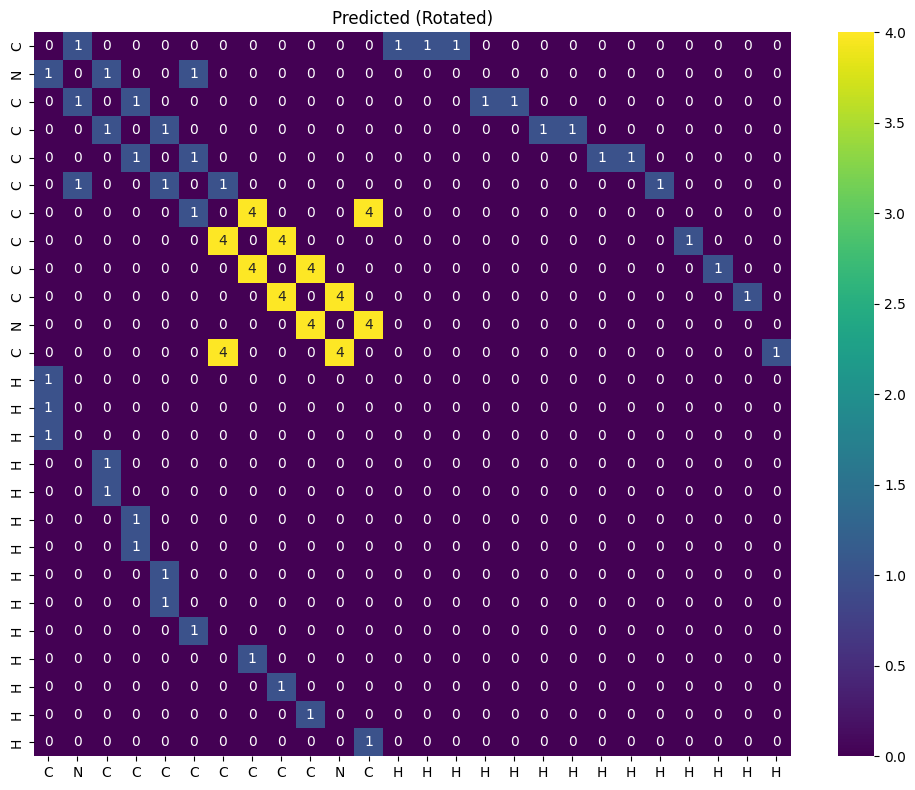

In [21]:
coordinates, atom_types, bond_matrix = rdkit_utils.embed_molecule_for_torch(mol)

visualize_bond_matrix(bond_matrix, atom_types)
plt.title('Ground Truth')
plt.show()

edge_index = e3tools.radius_graph(coordinates, r=net.radial_cutoff)
output = net(coordinates, atom_types, edge_index)
output = output.argmax(dim=-1).detach()
visualize_bond_matrix(output, atom_types)
plt.title('Predicted')
plt.show()

# Rotate the molecule and visualize the bond matrix
R = e3nn.o3.rand_matrix()
coordinates = coordinates @ R.T
edge_index = e3tools.radius_graph(coordinates, r=net.radial_cutoff)
output = net(coordinates, atom_types, edge_index)
output = output.argmax(dim=-1).detach()
visualize_bond_matrix(output, atom_types)
plt.title('Predicted (Rotated)')
plt.show()